In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [12]:
def information(N):#输入比特流的个数N，输出我们的信号，要么是1，要么是0
    signal=np.array([])
    for i in range(N):
        x=random.randint(0,1)
        if x>=0.5:
            x=1
        else:
            x=0
        signal=np.insert(signal,len(signal),x*2-1)
    return signal

In [3]:
def genMseq(b):#b为c0-cn的个数   b0对应Cn，bn对应C0
    N=len(b)-1#N指寄存器个数
    D=np.ones(N)#寄存器初始状态全1
    A=b[N-1::-1]
    #print(A)
    c=np.array([])
    for i in range((2**N)-1): #循环
        c1=(np.dot(D,A))%2#点乘求和，并与2求余数
        #print(c1)
        c=np.insert(c,len(c),D[N-1])
        D=D[0:N-1]
        D=np.insert(D,0,c1)
        #print(D)
    for i in range(len(c)):
        c[i]=int(c[i]*2-1)
    return c

In [4]:
def dsss(signal,c):
    ssignal=np.array([])
    for i in range(len(signal)):
        ssignal=np.insert(ssignal,len(ssignal),signal[i]*c)
    return ssignal 

In [5]:
def modu(signal,dataRate,fc,fs):#dataRate符号周期 fc载波频率 fs采样频率    Tb=1/dataRate
    t=np.linspace(0,1/dataRate,int(fs/dataRate))
    carrier=np.array([])
    carrier=np.insert(carrier,len(carrier),np.cos(2*(np.pi)*fc*t))
    #print(carrier)
    modusignal=np.array([])
    for i in range(len(signal)):
        modusignal=np.insert(modusignal,len(modusignal),signal[i]*carrier)
    return modusignal

In [6]:
def awgn(x, snr):
    snr = 10**(snr/10.0)
    xpower = np.sum(x**2)/len(x)
    npower = xpower/snr
    return np.random.randn(len(x)) * np.sqrt(npower)+x

In [7]:
#解扩
def dedsss(receiveSignal,c,chipRate,fs):
    L=int(fs/chipRate)#16
    c1=np.array([])
    a=np.ones(L)
    for i in range(len(c)):
        c1=np.insert(c1,len(c1),c[i]*a)
    dessignal=np.array([])
    for i in range(0,len(receiveSignal),len(c1)):
        h=receiveSignal[i:i+len(c1)]
        dessignal=np.insert(dessignal,len(dessignal),h*c1)
    return dessignal

In [8]:
def demodu(Resignal,datarate,fc,fs):
    t=np.linspace(0,1/datarate,int(fs/datarate))
    carrier=np.array([])
    carrier=np.insert(carrier,len(carrier),np.cos(2*(np.pi)*fc*t))
    Lc=len(carrier)
    Ls=len(Resignal)
    designal=np.array([])
    for i in range(0,Ls,Lc):
        h=Resignal[i:i+Lc]
        designal=np.insert(designal,len(designal),h*carrier)
    demoSignal=np.array([])
    sum=0
    for i in range(0,Ls,Lc):
        threshold=np.sum(designal[i:i + Lc - 1])
        if threshold>0:
            tt=1
        else:
            tt=-1
        demoSignal=np.insert(demoSignal,len(demoSignal),tt)
    return demoSignal

用户1的误比特率： [0.09       0.08       0.05333333 0.02333333 0.00666667 0.00333333]
用户2的误比特率： [0.13       0.06666667 0.05333333 0.01       0.01       0.        ]
用户3的误比特率： [0.15666667 0.08333333 0.07       0.06       0.02       0.        ]


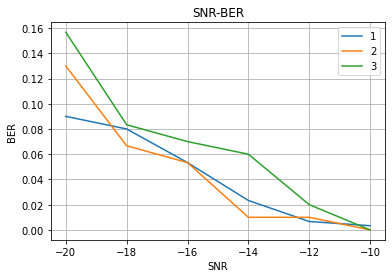

In [9]:
dataRate=1000
chipRate=31*dataRate
fc=chipRate*2
fs=fc*8
N=300
c=31
b1=[1,0,0,1,0,1]
b2=[1,1,0,1,1,1]
b3=[1,1,1,1,0,1]
snr=np.array([])
for i in range(-20,-8,2):
    snr=np.insert(snr,len(snr),i)
#print(snr)
err_bit1=np.array([])
err_bit2=np.array([])
err_bit3=np.array([])
for j in range(len(snr)):
    signal1=information(N)
    signal2=information(N)
    signal3=information(N)
    c1=genMseq(b1)
    c2=genMseq(b2)
    c3=genMseq(b3)
    dssignal1=dsss(signal1,c1)
    dssignal2=dsss(signal2,c2)
    dssignal3=dsss(signal3,c3)
    modusignal1=modu(dssignal1,chipRate,fc,fs)
    modusignal2=modu(dssignal2,chipRate,fc,fs)
    modusignal3=modu(dssignal3,chipRate,fc,fs)
    mixsignal=modusignal1+modusignal2+modusignal3
    receivesignal=awgn(mixsignal,snr[j])
    dedssignal1=dedsss(receivesignal,c1,chipRate,fs)
    demoSignal1=demodu(dedssignal1,dataRate,fc,fs)
    dedssignal2=dedsss(receivesignal,c2,chipRate,fs)
    demoSignal2=demodu(dedssignal2,dataRate,fc,fs)
    dedssignal3=dedsss(receivesignal,c3,chipRate,fs)
    demoSignal3=demodu(dedssignal3,dataRate,fc,fs)
    q=0
    for i in range(len(signal1)):
        if demoSignal1[i]!=signal1[i]:
            q=q+1
    err_bit1=np.insert(err_bit1,j,q/N)
    p=0
    for i in range(len(signal2)):
        if demoSignal2[i]!=signal2[i]:
            p=p+1
    err_bit2=np.insert(err_bit2,j,p/N)
    s=0
    for i in range(len(signal3)):
        if demoSignal3[i]!=signal3[i]:
            s=s+1
    err_bit3=np.insert(err_bit3,j,s/N)
print("用户1的误比特率：",err_bit1)
#print("发射信号:",signal1)
#print("解调信号:",demoSignal1)
print("用户2的误比特率：",err_bit2)
#print("发射信号:",signal2)
#print("解调信号:",demoSignal3)
print("用户3的误比特率：",err_bit3)
#print("发射信号:",signal3)
#print("解调信号:",demoSignal3)
plt.plot(snr,err_bit1)
plt.plot(snr,err_bit2)
plt.plot(snr,err_bit3)
plt.grid()
plt.legend("123",loc='upper right')
plt.xlabel('SNR')
plt.ylabel('BER')
plt.title('SNR-BER')
plt.show()